12.497226710998131 1.5124932845789727


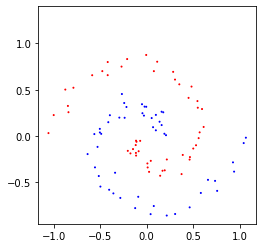

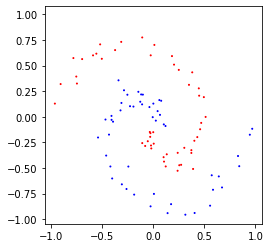

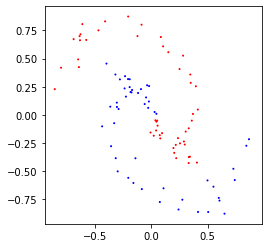

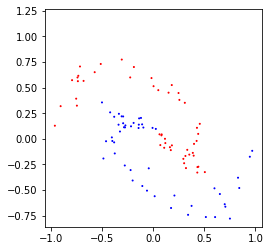

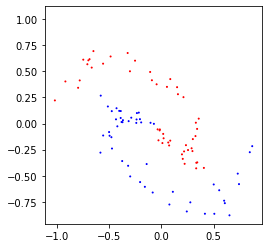

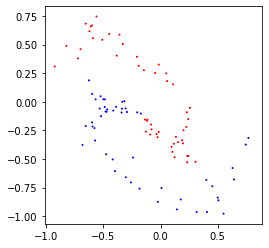

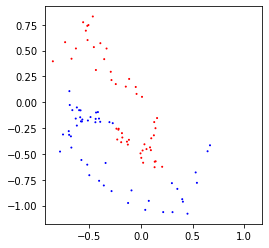

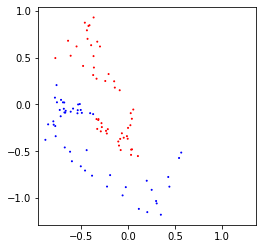

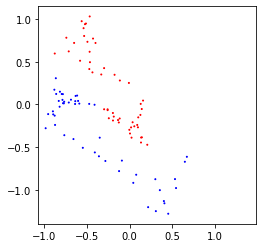

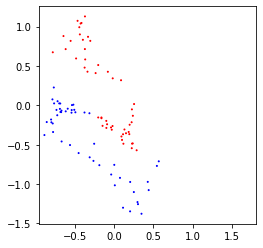

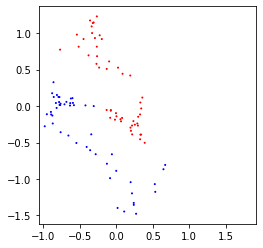

In [0]:
import numpy as np
import matplotlib.pyplot as plt

I = 100  #antall bilder, kan økes til 1000 punkter/bilder
d = 2   #x- og y-koordinat
K = 10  #antall transformajsoner, kan økes til 15-20
h = 0.1 #skrittlengde
iterations = 1000  #kan økes til 40 000

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    return np.cosh(x)**(-2)

def eta(x):
    return 0.5*(1+np.tanh(x/2))

def eta_der(x):
    return np.e**(x)*(np.e**(x)+1)**(-2)

def make_spiral(m, phi, n_turns):
    '''Makes points on a spiral
    
    This is a utility function for get_data_spiral_2d'''
    r = np.linspace(0.1, 1.0, m)
    a = np.linspace(0.1, 2.0 * np.pi * n_turns, m)
    xs = r * np.cos(a + phi)
    ys = r * np.sin(a + phi)
    return np.stack([xs, ys])

def get_data_spiral_2d(n_samples=I): #Stod n_samples=200
    '''Create "observations" for training.
    
    Creates n_samples dots on two intertwined spirals.
    The dots are classified based on which spiral they belong to and
    then fuzzed by perturbing the coordinates and permuting the ordering.'''
    m1 = math.ceil(n_samples / 2)
    m2 = n_samples - m1
    
    n_turns = 1.0
    
    phi1 = np.pi
    d1 = make_spiral(m1, phi1, n_turns)

    
    phi2 = (phi1 + np.pi) % (2.0 * np.pi)
    d2 = make_spiral(m2, phi2, n_turns)
    
    features = np.hstack((d1, d2))
    labels = np.ones((n_samples,1), dtype='bool_')
    labels[m1:] = False
    
    features = features + .05 * np.random.randn(*features.shape)
    
    indexes = np.random.permutation(n_samples)
    features = features[:, indexes]
    labels = labels[indexes]

    return features, labels

def adam_method(x, x_der, m_jn, v_jn):
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def plain_vanilla(x,x_der):
    x -= tau*x_der
    return x
    
#Forberedelser:
Y_0, c = get_data_spiral_2d()  #c er fasiten
c = c[:,0]  #for å få en Ix1 vektor 
Y_Kk = np.zeros((K+1,d,I))  #Med K transformasjoner får vi K+1 Y_k'er
Y_Kk[0,:,:] = Y_0
b_k_dim = np.zeros((K,d,I))

#Til Adam-metoden:
beta_1 = 0.9
beta_2 = 0.999
alfa = 0.01
epsilon = 1e-8
v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])

#Til Plain vanilla:
tau = 0.05

#Parameters that changes for each while loop
W_k = np.random.randn(K,d,d)
b_k = np.random.randn(K,d,1)  
omega = np.random.randn(d)  
my = np.random.rand() 

j = 1   #Må starte på 1
J = np.zeros(iterations)
#W_k er en dxd matrise og  (2x2 for leketøysmodellen)
#b_k er en dx1 vektor elementer for hver k  (2x1 for leketøysmodellen)
#Y_k er en dxI matrise med kolonne i som den i'te bildet (hver kolonne har dimensjoner dx1)
# c en en Ix1 vektor, (labels fra get_data_spiral)
while j <= iterations:
    for i in range(K): 
        b_k_dim[i,:,:] = b_k[i,:,:]   #Lager I kolonner med b_k[i,:,:] for å kunne plusse sammen med en dxI matrise
        Y_Kk[i+1,:,:] = Y_Kk[i,:,:] + h*sigma(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])  #plusser b_k med alle kolonnene i Y_Kk

    YT_k = np.transpose(Y_Kk[-1,:,:]) #Enklere notasjon
    vec_I = np.ones(I)
    Z = eta(YT_k @ omega + my*vec_I)  #Z er en Ix1 vektor
    J[j-1] = 0.5*np.linalg.norm(Z-c)**2 #J blir en array med iterations antall verdier
    
    P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my*vec_I)) #Blir en dxI matrise
    J_der_my = eta_der(YT_k @ omega + my*vec_I) @ (Z-c)    #Blir en skalar  
    J_der_omega = Y_Kk[-1,:,:] @ ((Z-c) * eta_der(YT_k @ omega + my*vec_I)) #Blir en dx1 vektor
    
    P_Kk = np.zeros((K,d,I)) #K matriser, skal ikke ha med P_0
    P_Kk[-1,:,:] = P_k      #Legger P_k bakerst i P_Kk
    for i in range(K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
        P_Kk[i-1,:,:] = P_Kk[i,:,:] + h*np.transpose(W_k[i-1,:,:]) @ (sigma_der(W_k[i-1,:,:] @ Y_Kk[i-1,:,:] +b_k_dim[i-1,:,:]) * P_Kk[i,:,:])
    
    J_der_W = np.zeros((K,d,d))
    J_der_b = np.zeros((K,d,1))
    vec_I = np.ones((I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
    #P_Kk går fra P_1(=indeks 0) til P_K(=indeks K-1)
    for i in range(K):
        val = P_Kk[i,:,:] * sigma_der(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])
        J_der_W[i,:,:] = h*(val @ np.transpose(Y_Kk[i,:,:]))
        J_der_b[i,:,:] = h*(val @ vec_I)
    
    #Adam-metoden, oppdaterer alle verider.
    my, m_j[0],v_j[0] = adam_method(my,J_der_my,m_j[0],v_j[0])
    omega, m_j[1],v_j[1] = adam_method(omega,J_der_omega,m_j[1],v_j[1]) 
    b_k, m_j[2],v_j[2] = adam_method(b_k,J_der_b,m_j[2],v_j[2])
    W_k, m_j[3],v_j[3] = adam_method(W_k,J_der_W,m_j[3],v_j[3]) 
    
    #Plain vanilla
    #my = plain_vanilla(my,J_der_my)
    #omega = plain_vanilla(omega, J_der_omega)
    #b_k = plain_vanilla(b_k,J_der_b)
    #W_k = plain_vanilla(W_k, J_der_W)
    j+= 1


print(J[0],J[-1])  #god overeenstemmelse

###Visuals:
def show_dots(positions, labels):
    '''Visualize the output of get_data_spiral_2d'''
    plt.scatter(x=positions[0,:], y=positions[1,:], s=1, c=labels, cmap='bwr')
    plt.axis([-1.2, 1.2, -1.2, 1.2])
    plt.axis('square')
    
def plot_progression(Y, C):
    for k in range(Y.shape[0]):
        show_dots(Y[k,:,:],C)
        plt.show()

plot_progression(Y_Kk, c) 




In [0]:
##Alt dette er kopiert inn fra plotting.py fra Brynjulf
#Kunne vi heller importert en fil inn i Colab?  Typ; from plotting import*
def get_box(Ys):
    xmin = min(Ys[0,:])
    xmax = max(Ys[0,:])
    xdelta = xmax-xmin
    xmin -= 0.2*xdelta
    xmax += 0.2*xdelta
    ymin = min(Ys[1,:])
    ymax = max(Ys[1,:])
    ydelta = ymax-ymin
    ymin -= 0.2*ydelta
    ymax += 0.2*ydelta
    return xmin, xmax, ymin, ymax

def get_grid(xcoordinates, ycoordinates):
    xv, yv = np.meshgrid(xcoordinates, ycoordinates)
    xs = xv.reshape(-1)
    ys= yv.reshape(-1)
    grid = np.stack([xs,ys])
    return grid

def get_grid_and_stuff(Ys, n):
    xmin, xmax, ymin, ymax = get_box(Ys)
    xcoordinates = np.linspace(xmin, xmax, n)
    ycoordinates = np.linspace(ymin, ymax, n)
    grid = get_grid(xcoordinates, ycoordinates)
    coordinates = ([xmin, xmax, ymin, ymax], xcoordinates, ycoordinates)
    return grid, coordinates

def plot_contours(box, xcoordinates, ycoordinates, Z, l, Ys, C1):
    n = xcoordinates.size
    plt.contourf(xcoordinates, ycoordinates, Z.reshape((n,n)), cmap='seismic', levels=l)
    plt.contour(xcoordinates, ycoordinates, Z.reshape((n,n)), levels=1, colors='k')
    plt.scatter(x=Ys[0,:], y=Ys[1,:], s=1, c=C1, cmap='bwr')
    plt.axis(box)
    plt.axis('equal')
    plt.show()

def shading(x):
    if x == 0.0:
        return 0.0
    return 0.5 * np.tanh(np.tan(x * np.pi + np.pi / 2.0)) + 0.5

def shading2(x):
    if x < 0.5:
        return 0.5 - np.sqrt(0.25 - x**2)
    else:
        return 0.5 + np.sqrt(0.25 -(x-1.0)**2)

def plot_separation(model, Ys, C, n):
    grid, coordinates = get_grid_and_stuff(Ys, n)

    Z = model.fast_landscape(grid)
    l = np.linspace(0,1,500)

    plot_contours(*coordinates, Z, l, Ys, C)

def plot_model(model, Ys, C, n):
    grid, coordinates = get_grid_and_stuff(Ys, n)

    Z = model.fast_forward(grid)
    l = np.linspace(0,1,8)
    l = np.array([shading(shading2(x)) for x in l])
    
    plot_contours(*coordinates, Z, l, Ys, C)

#model er hva?? - ikke en np.array i hvert fall - må spørre om dette!!
#plot_model(model, Ys, c, n)
#plot_seperation(model,Ys,C,n)